# ECS 171 Project: Detecting Cyber Intrusion on IoT Traffic Data


#### Completed by Matthew Armstrong, Rahul Prabhu, Matthew Tom, and Kyle Tsuji
##### *Professor Solares, ECS 171: Machine Learning - UC Davis Summer 2023*

## Imports and Data Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# get dataset from github archive
!wget https://github.com/matthewarmstr/ECS-171-Project/raw/main/IoT_Intrusion.zip
!unzip IoT_Intrusion.zip

--2023-09-13 18:36:32--  https://github.com/matthewarmstr/ECS-171-Project/raw/main/IoT_Intrusion.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matthewarmstr/ECS-171-Project/main/IoT_Intrusion.zip [following]
--2023-09-13 18:36:33--  https://raw.githubusercontent.com/matthewarmstr/ECS-171-Project/main/IoT_Intrusion.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48101046 (46M) [application/zip]
Saving to: ‘IoT_Intrusion.zip’

IoT_Intrusion.zip   100%[===================>]  45.87M  58.8MB/s    in 0.8s    

2023-09-13 18:36:36 (58.8 MB/s) - ‘IoT_Intrusion.zip’ saved [48101046/48101046]


In [3]:
# load data file
intru_table = pd.read_csv("IoT_Intrusion.csv")
intru_labels_removed = intru_table.drop(columns=['label'])

## Data Preprocessing

In [4]:
# save attribute and label strings
all_attribute_names = intru_table.columns.drop('label')

intru_label_names = ['Backdoor_Malware', 'BenignTraffic', 'BrowserHijacking', 'CommandInjection', 'DDoS-ACK_Fragmentation', 'DDoS-HTTP_Flood', 'DDoS-ICMP_Flood', 'DDoS-ICMP_Fragmentation',
                     'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood', 'DDoS-SlowLoris', 'DDoS-SynonymousIP_Flood', 'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DDoS-UDP_Fragmentation',
                     'DNS_Spoofing', 'DictionaryBruteForce', 'DoS-HTTP_Flood', 'DoS-SYN_Flood', 'DoS-TCP_Flood', 'DoS-UDP_Flood', 'MITM-ArpSpoofing', 'Mirai-greeth_flood', 'Mirai-greip_flood',
                     'Mirai-udpplain', 'Recon-HostDiscovery', 'Recon-OSScan', 'Recon-PingSweep', 'Recon-PortScan', 'SqlInjection', 'Uploading_Attack', 'VulnerabilityScan', 'XSS']

In [5]:
# complete one-hot encoding on intrusion labels
ohe = OneHotEncoder()
ohe_intru_labels = pd.DataFrame(ohe.fit_transform(intru_table['label'].values.reshape(-1,1)).toarray(), columns=intru_label_names)

In [6]:
# we decided to remove the following attributes since they provide no meaningful contributions to the model
exclude = ['ece_flag_number', 'cwr_flag_number', 'SMTP', 'Telnet', 'IRC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'Covariance', 'Variance']

relevant = ['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate',
         'syn_count', 'fin_count', 'urg_count', 'rst_count', 'IPv', 'LLC', 'DNS', 'SSH', 'TCP', 'UDP',
         'DHCP', 'ARP', 'ICMP', 'IAT', 'Number', 'Mangitue', 'Radius', 'Weight']

# remove unwanted data attribute columns
attribute_data = intru_labels_removed.drop(columns=exclude)

# split data for all model runs
X_train, X_test, y_train, y_test = train_test_split(attribute_data, ohe_intru_labels, train_size=0.9, random_state=5)

In [7]:
# check if each attribute is normally distributed
for col_name in attribute_data:
    print(col_name, shapiro(attribute_data[col_name]), "\n\tmin:", np.min(attribute_data[col_name]), "; max:", np.max(attribute_data[col_name]))

flow_duration ShapiroResult(statistic=0.0039147138595581055, pvalue=0.0) 
	min: 0.0 ; max: 99435.76178
Header_Length ShapiroResult(statistic=0.1560286283493042, pvalue=0.0) 
	min: 0.0 ; max: 9815555.0
Protocol Type ShapiroResult(statistic=0.6346024870872498, pvalue=0.0) 
	min: 0.0 ; max: 47.0
Duration ShapiroResult(statistic=0.18483299016952515, pvalue=0.0) 
	min: 0.0 ; max: 255.0
Rate ShapiroResult(statistic=0.05927008390426636, pvalue=0.0) 
	min: 0.0 ; max: 7340032.0
Srate ShapiroResult(statistic=0.05927008390426636, pvalue=0.0) 
	min: 0.0 ; max: 7340032.0
Drate ShapiroResult(statistic=9.66191291809082e-05, pvalue=0.0) 
	min: 0.0 ; max: 0.848465429
fin_flag_number ShapiroResult(statistic=0.3147495985031128, pvalue=0.0) 
	min: 0 ; max: 1
syn_flag_number ShapiroResult(statistic=0.499664306640625, pvalue=0.0) 
	min: 0 ; max: 1
rst_flag_number ShapiroResult(statistic=0.32291436195373535, pvalue=0.0) 
	min: 0 ; max: 1
psh_flag_number ShapiroResult(statistic=0.3181704878807068, pvalue=0.0)

In [8]:
# attributes are NOT normally distributed (all p-values < 0.05) - normalize traffic attribute data in train and test sets
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=attribute_data.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=attribute_data.columns)

## Data Visualization

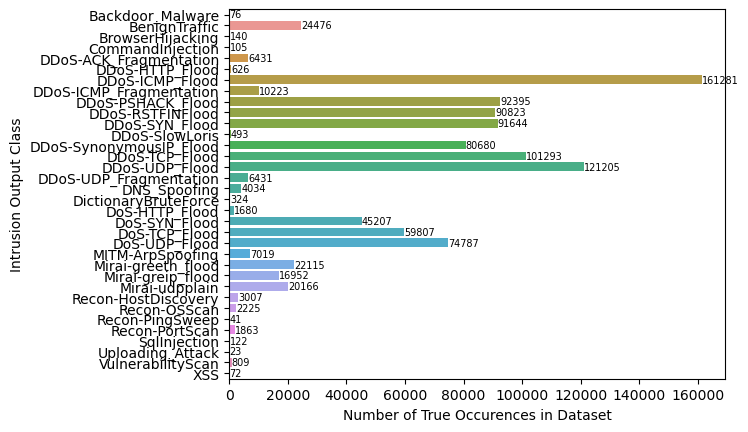

In [ ]:
# show output class distribution
classes_true_count = []
for col in ohe_intru_labels:
    count = (ohe_intru_labels[col] == 1).sum()
    classes_true_count.append(count)
class_distru = pd.DataFrame({'Intrusion Output Class': ohe_intru_labels.columns, 'Number of True Occurences in Dataset': classes_true_count})
fig, ax = plt.subplots()
sns.barplot(x='Number of True Occurences in Dataset', y='Intrusion Output Class', data=class_distru)
for i in ax.containers:
    ax.bar_label(i, fontsize=7)

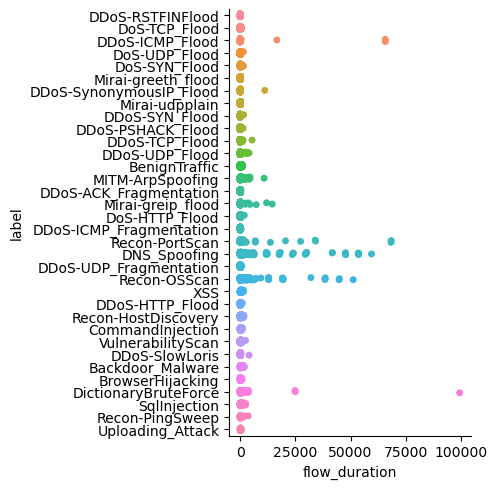

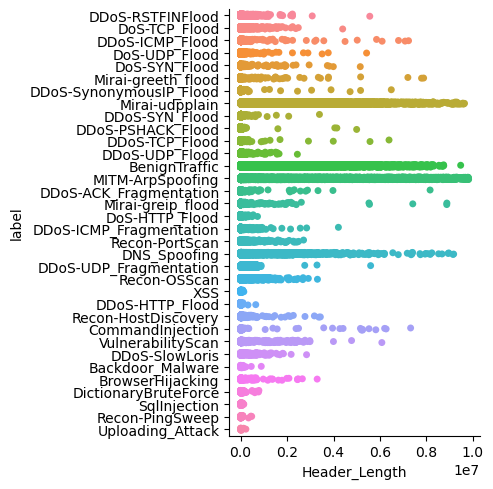

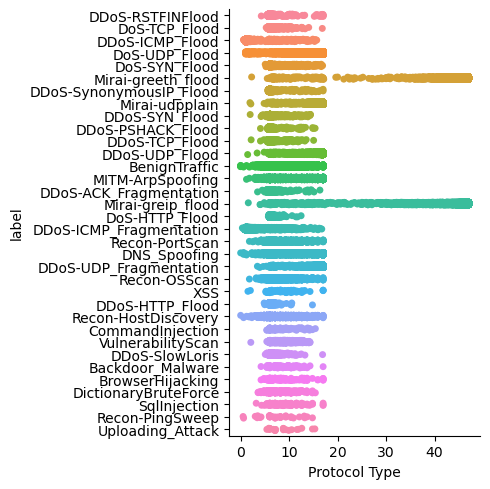

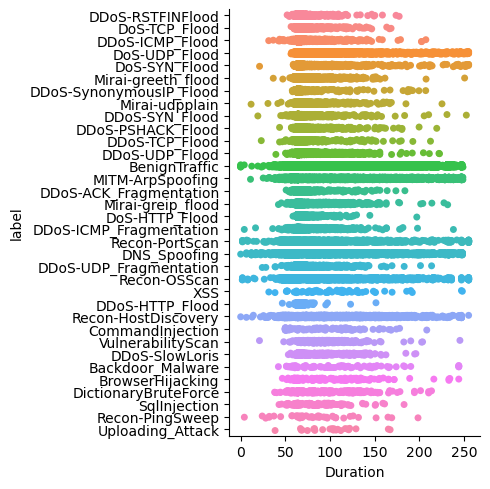

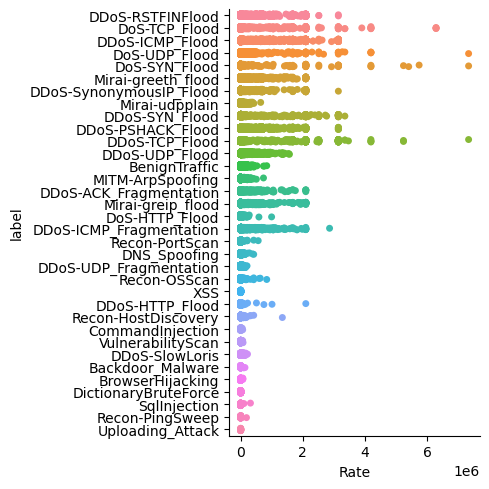

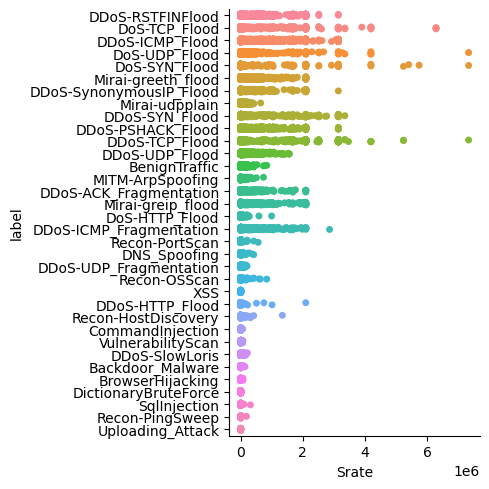

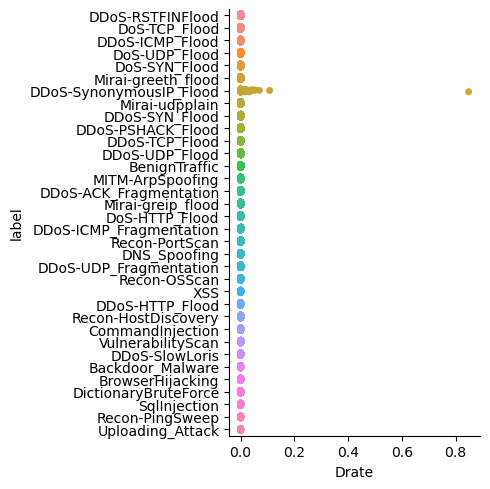

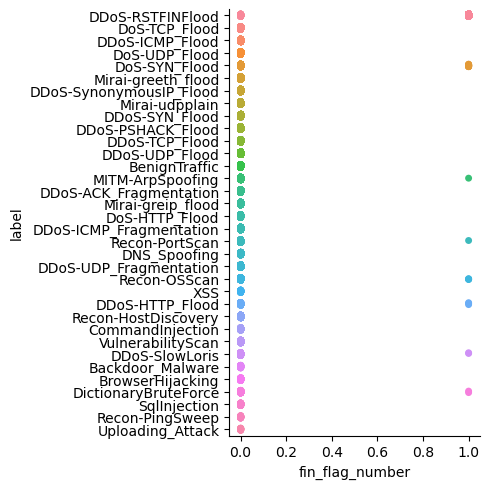

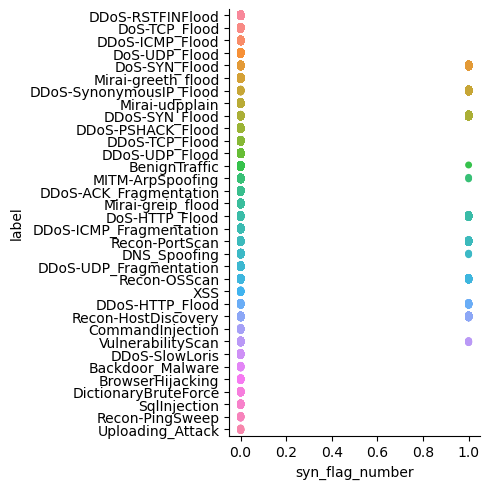

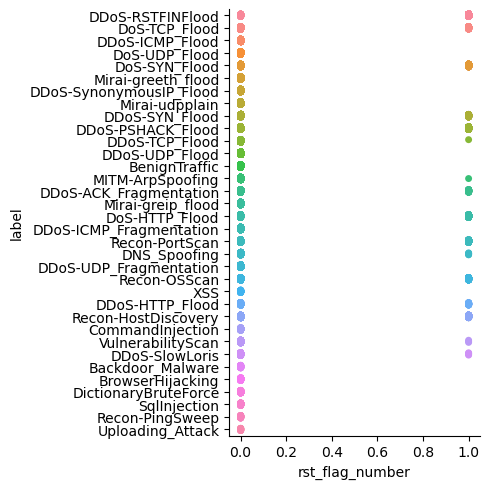

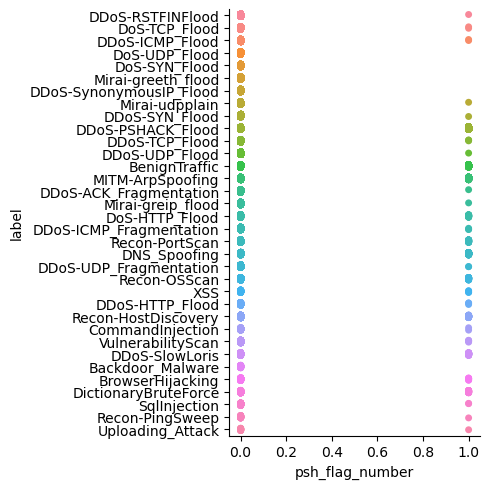

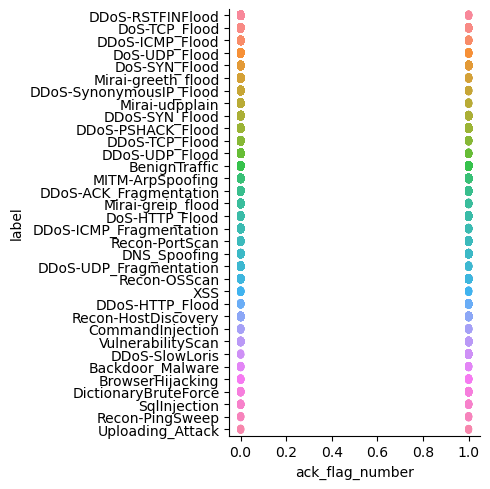

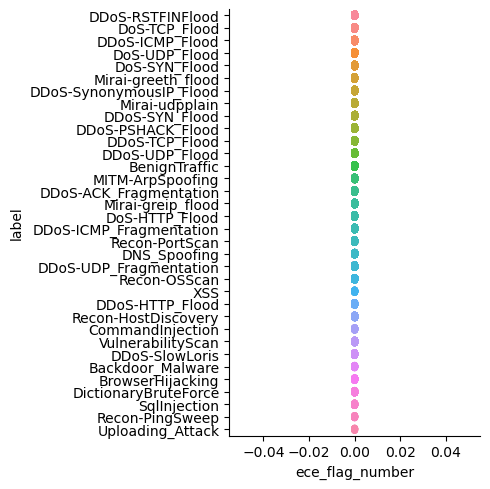

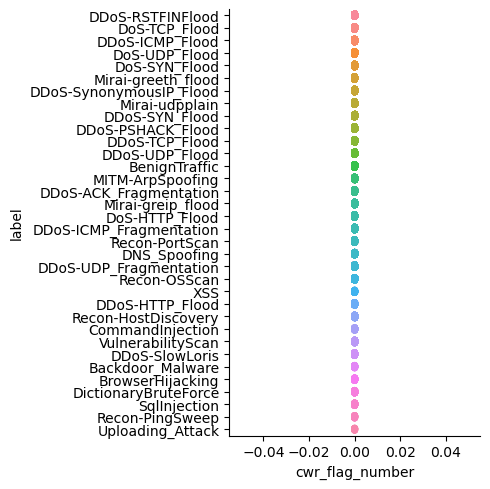

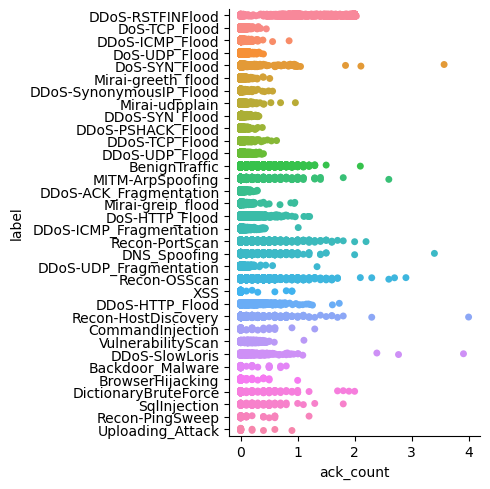

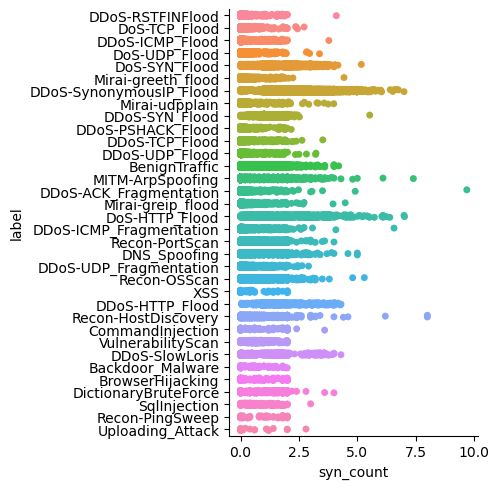

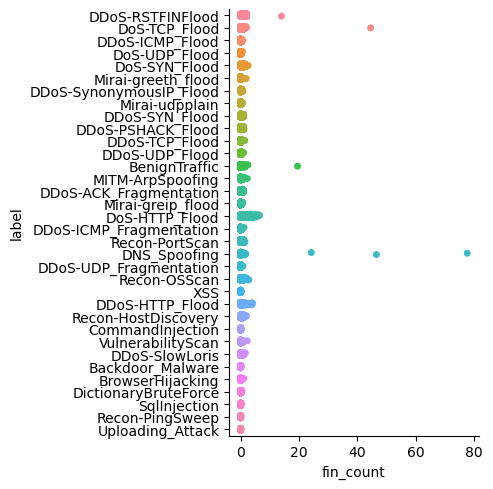

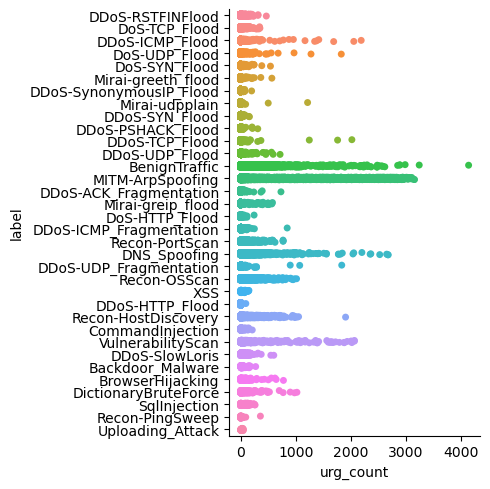

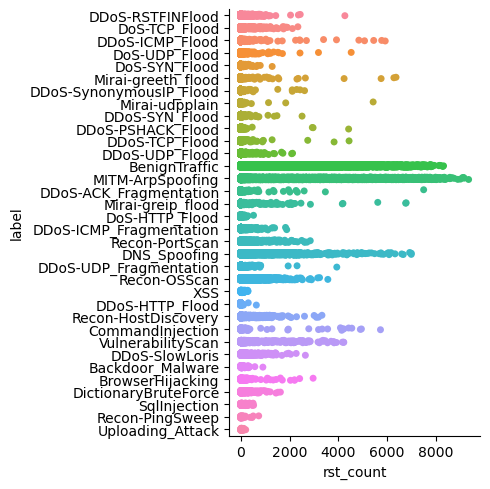

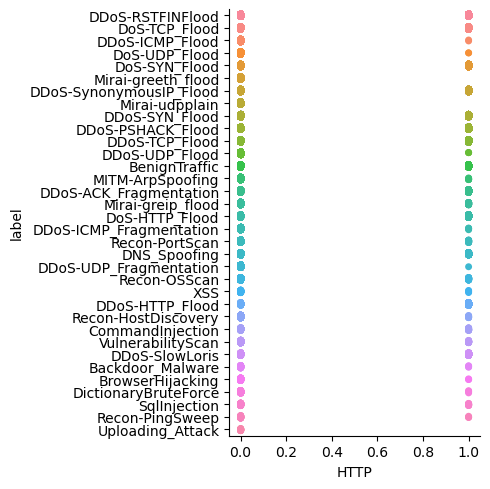

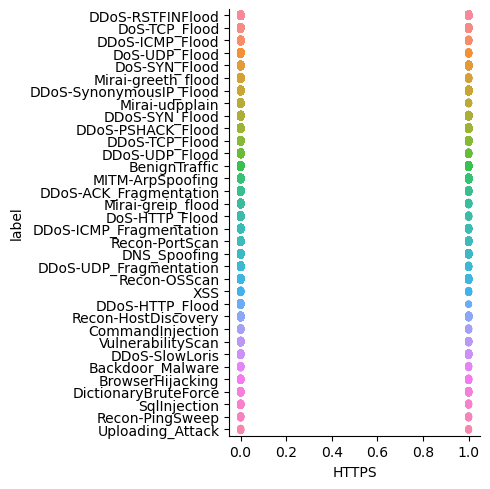

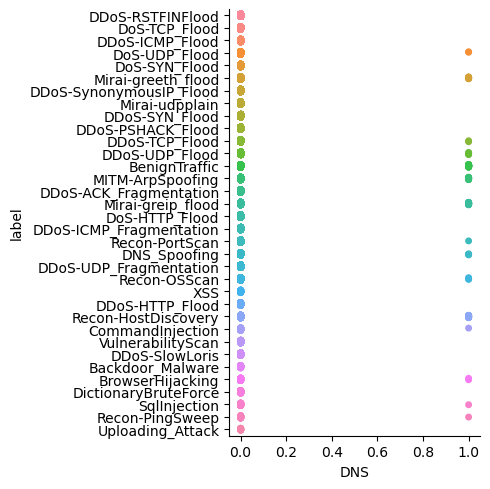

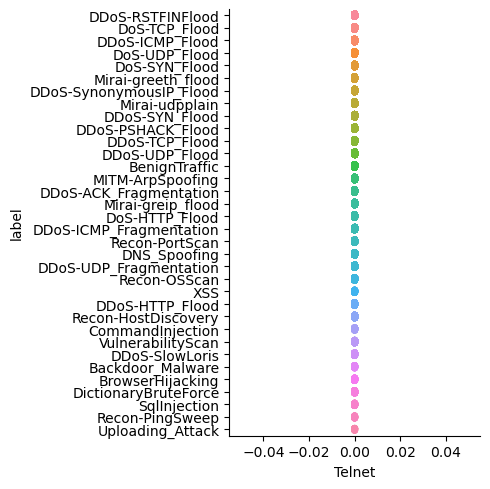

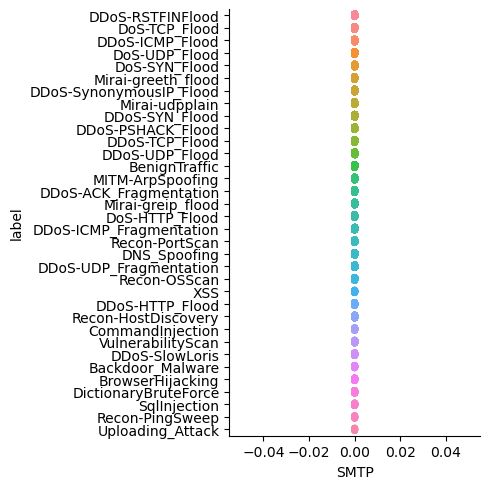

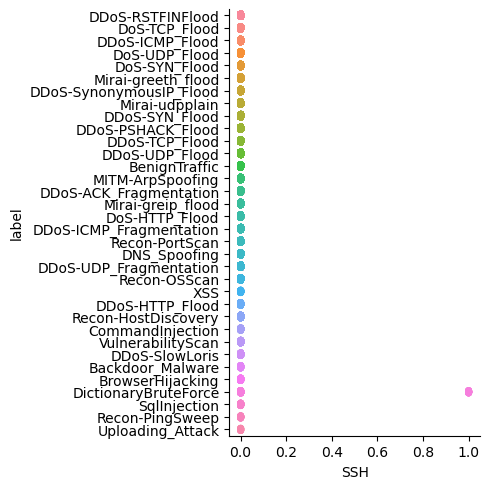

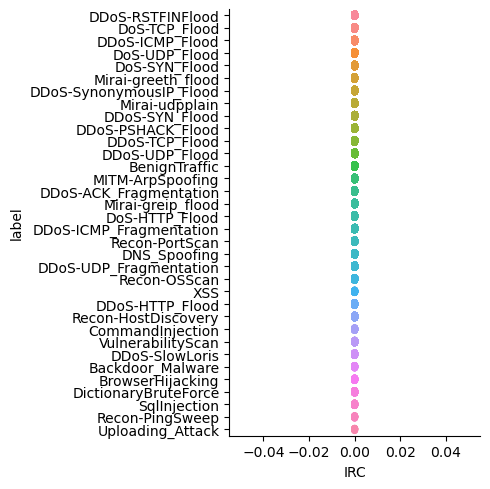

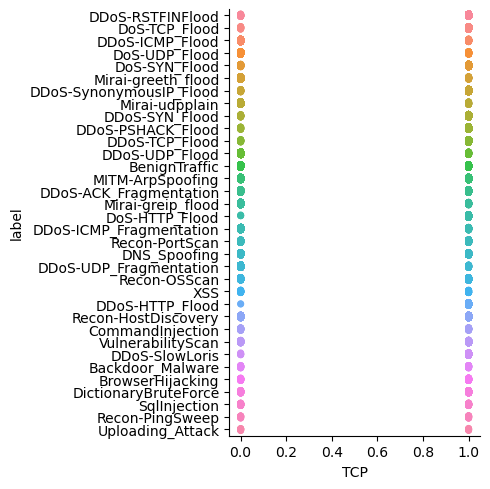

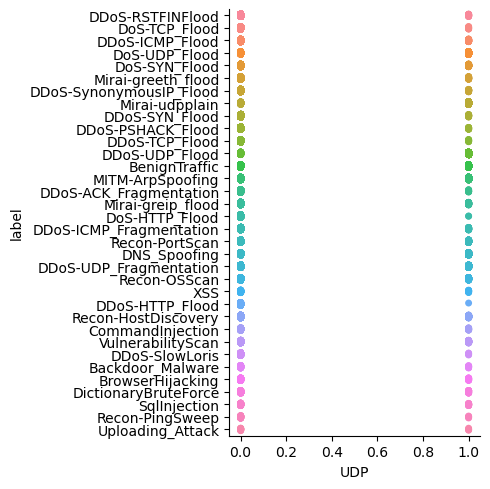

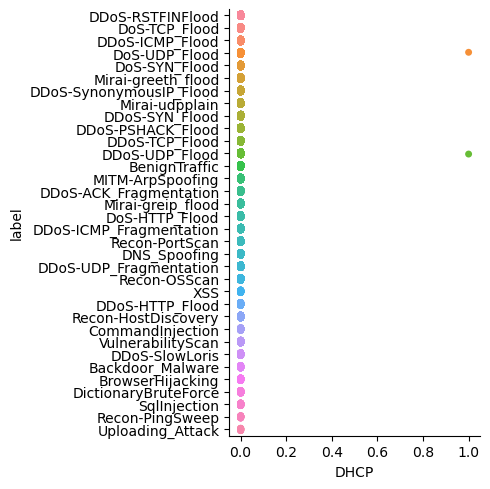

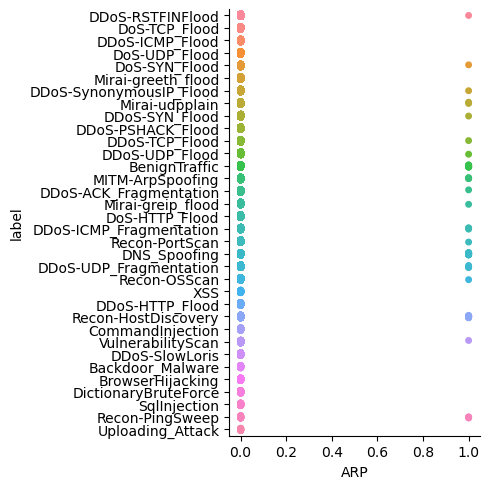

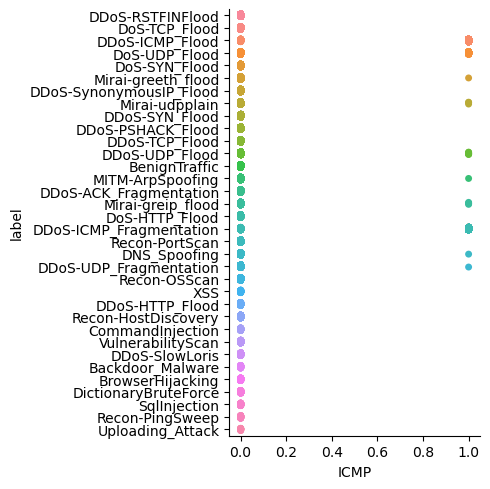

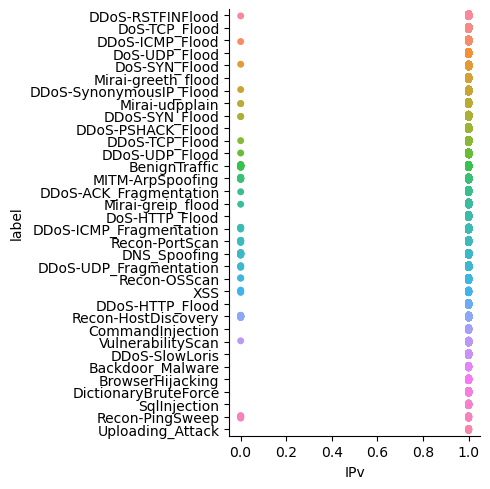

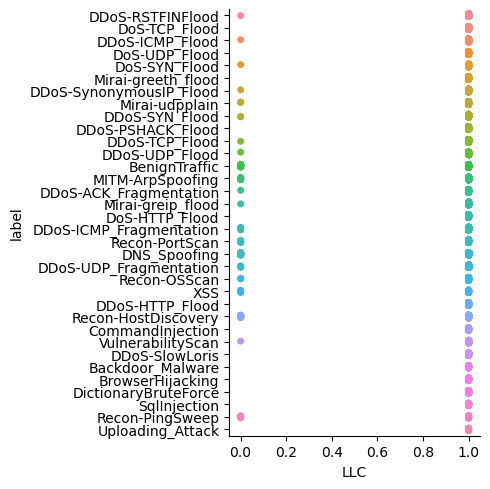

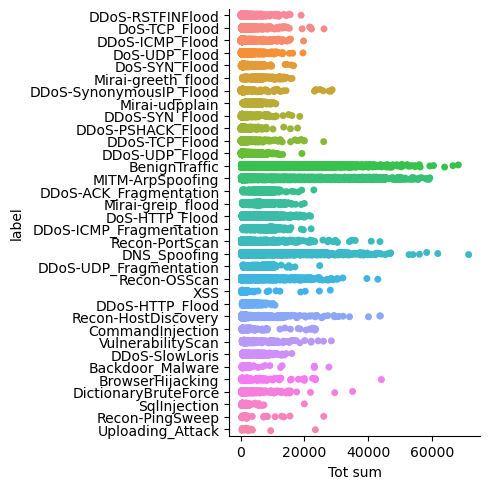

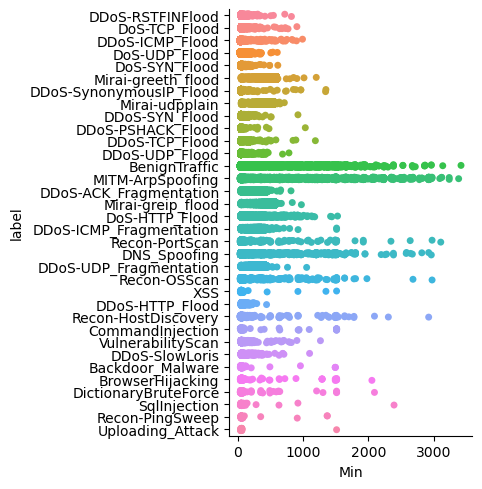

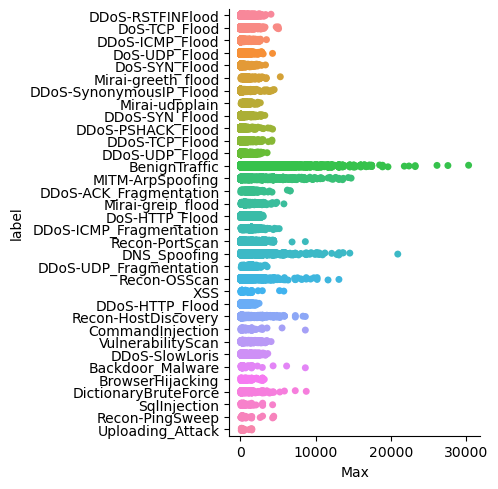

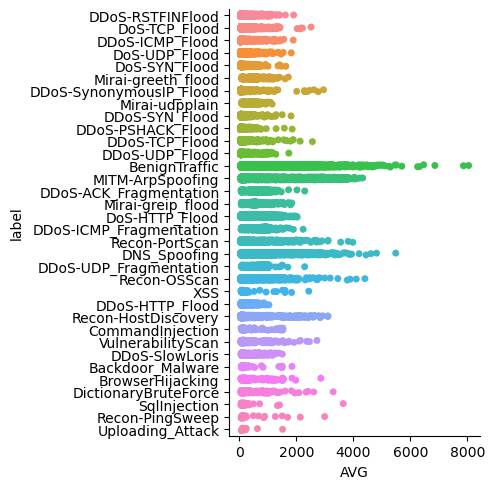

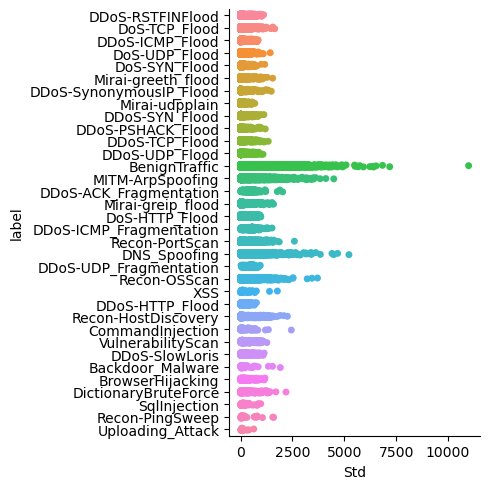

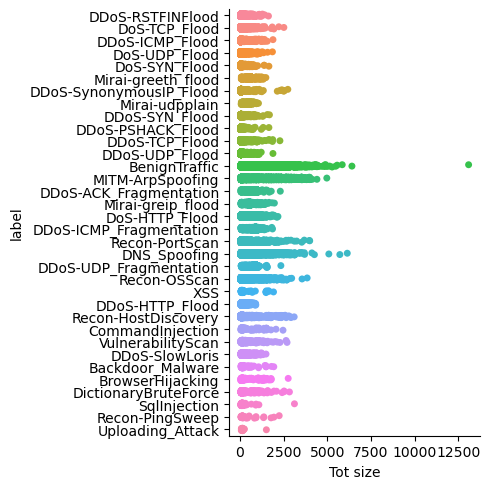

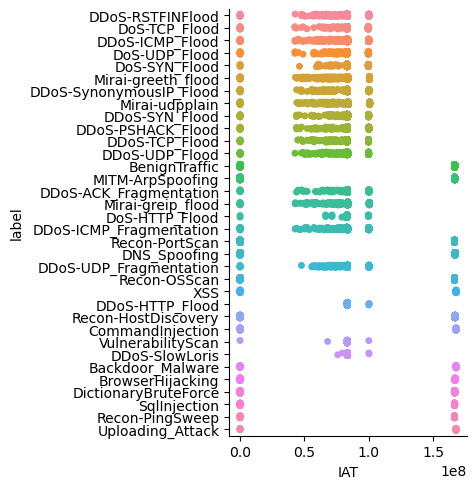

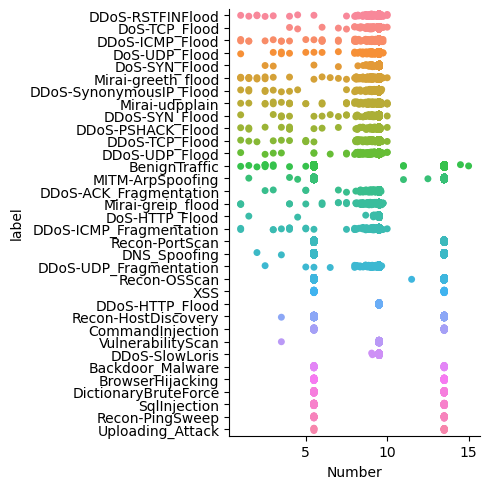

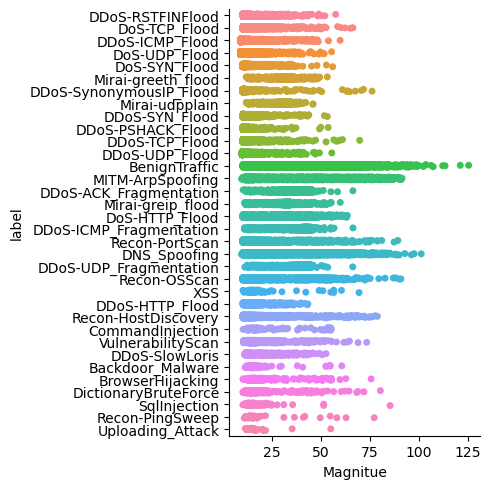

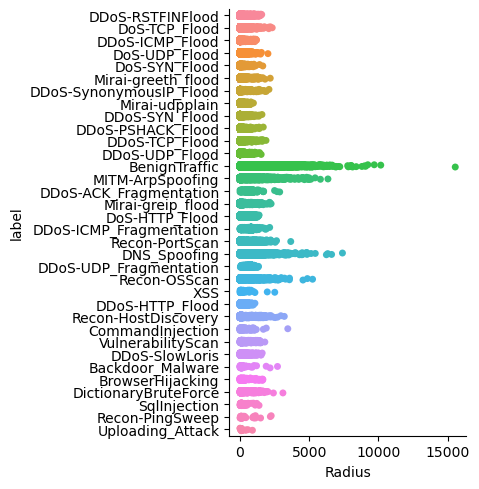

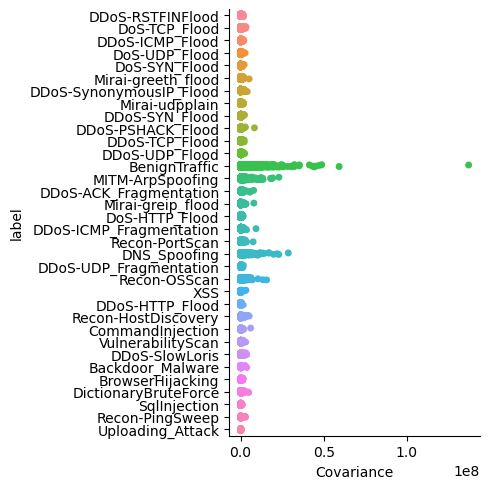

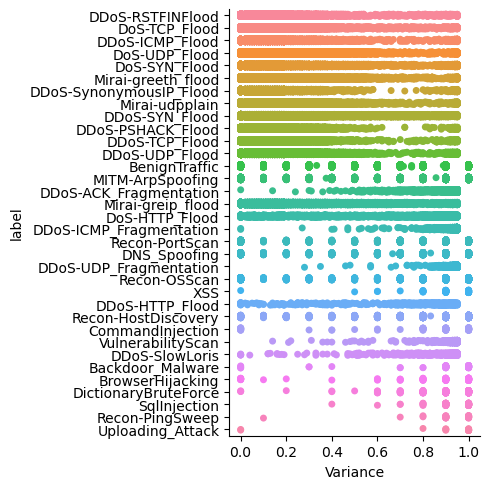

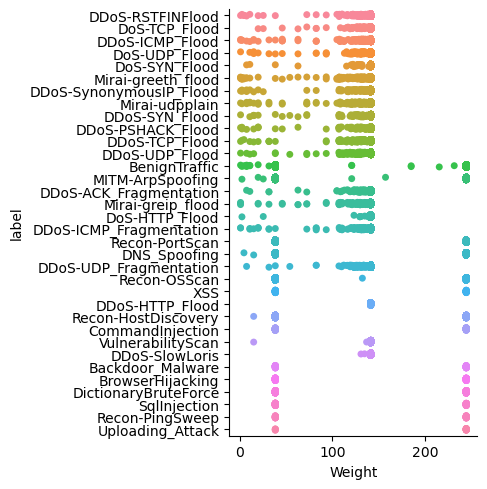

In [ ]:
# create catplots showing distributions of outputs against all inputs
# (used for-loop because creating one pairplot used too much memory)
for name in intru_table.columns:
    if name not in ['label']:
        sns.catplot(data=intru_table, x=name, y='label')

## Fitting the Initial Model and Measuring Its Performance

In [ ]:
# setup neural net for predicting intrusion class
classifier = Sequential()
classifier.add(Dense(units = 36, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 35, activation = 'relu'))
classifier.add(Dense(units = 34, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train.astype(float), y_train, epochs = 50)

In [ ]:
# INITIAL STATS
# measure performance on training data
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
initial_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", initial_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
initial_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", initial_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_intru_labels.columns))

29492/29492 [==============================] - 26s 881us/step
Model Training Accuracy (avg.): 0.8003066597295587
Model Training Precision (avg.): 0.6403201274107059
Model Training Recall (avg.): 0.48401263899986613
Model Training MSE: 0.011208619433455531
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        68
          BenignTraffic       0.79      0.85      0.82     22033
       BrowserHijacking       0.00      0.00      0.00       126
       CommandInjection       0.00      0.00      0.00        88
 DDoS-ACK_Fragmentation       0.99      0.98      0.98      5796
        DDoS-HTTP_Flood       0.68      0.52      0.59       579
        DDoS-ICMP_Flood       1.00      1.00      1.00    145241
DDoS-ICMP_Fragmentation       1.00      0.97      0.99      9235
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83181
       DDoS-RSTFINFlood       1.00      1.00      1.00     81774
         DDoS-SYN_Flood     

In [ ]:
# K-fold cross validation to generalize initial model performance (10 folds)
classifier = Sequential()
classifier.add(Dense(units = 36, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 35, activation = 'relu'))
classifier.add(Dense(units = 34, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
kfold_model = KFold(n_splits=10)

# calculate accuracy and MSE scores for each fold iteration
scaler = MinMaxScaler()
X = scaler.fit_transform(attribute_data)
y = ohe_intru_labels.values
all_accuracy = []
all_mse = []
count = 0
for train_index, test_index in kfold_model.split(X):
    count += 1
    classifier.fit(X[train_index].astype(float), y[train_index])
    bean_predictions_cla2 = pd.DataFrame(((classifier.predict(X[test_index].astype(float))) > 0.5).astype(int))
    iter_accuracy = accuracy_score(y[test_index], bean_predictions_cla2)
    print("\tIteration", count, "Accuracy:", iter_accuracy)
    all_accuracy.append(iter_accuracy)
    iter_mse = mean_squared_error(y[test_index], bean_predictions_cla2)
    print("\tIteration", count, "MSE:", iter_mse)
    all_mse.append(iter_mse)

# print results
print("Overall Avg. K-Fold Accuracy:", np.mean(all_accuracy))
print("Overall Avg. K-Fold MSE:", np.mean(all_mse))

3277/3277 [==============================] - 3s 804us/step
	Iteration 1 Accuracy: 0.7403917679147037
	Iteration 1 MSE: 0.013627953994926474
3277/3277 [==============================] - 4s 1ms/step
	Iteration 2 Accuracy: 0.6736729672509489
	Iteration 2 MSE: 0.017472368794549043
3277/3277 [==============================] - 3s 1ms/step
	Iteration 3 Accuracy: 0.7673425012874554
	Iteration 3 MSE: 0.012673161350981106
3277/3277 [==============================] - 4s 1ms/step
	Iteration 4 Accuracy: 0.7769268916057906
	Iteration 4 MSE: 0.012251302321458827
3277/3277 [==============================] - 4s 1ms/step
	Iteration 5 Accuracy: 0.7007381411051136
	Iteration 5 MSE: 0.013705930597457852
3277/3277 [==============================] - 3s 926us/step
	Iteration 6 Accuracy: 0.7756372965085784
	Iteration 6 MSE: 0.012505266275807558
3277/3277 [==============================] - 3s 1ms/step
	Iteration 7 Accuracy: 0.7744165863986191
	Iteration 7 MSE: 0.012634854527370329
3277/3277 [===================

## Identifying the Initial Model's Fitting Characteristics

In [ ]:
# LOW1 FIT
# setup neural net for predicting intrusion class
classifier = Sequential()
classifier.add(Dense(units = 16, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 15, activation = 'relu'))
classifier.add(Dense(units = 34, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train.astype(float), y_train, epochs = 50)

Epoch 1/50
29492/29492 [==============================] - 33s 1ms/step - loss: 0.7817
Epoch 2/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.5498
Epoch 3/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.5121
Epoch 4/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.4924
Epoch 5/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.4833
Epoch 6/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.4787
Epoch 7/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.4755
Epoch 8/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.4730
Epoch 9/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.4708
Epoch 10/50
29492/29492 [==============================] - 35s 1ms/step - loss: 0.4685
Epoch 11/50
29492/29492 [==============================] - 32s 1ms/step - loss: 0.4666
Epoch 12/50
29492/29492 [===========================

In [ ]:
# LOW1 STATS
# measure performance on training data
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
low1_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", low1_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
low1_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", low1_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_intru_labels.columns))

29492/29492 [==============================] - 22s 747us/step
Model Training Accuracy (avg.): 0.7912562770406806
Model Training Precision (avg.): 0.5859911331401575
Model Training Recall (avg.): 0.4419651985412158
Model Training MSE: 0.01183424317945765
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        68
          BenignTraffic       0.77      0.83      0.80     22033
       BrowserHijacking       0.00      0.00      0.00       126
       CommandInjection       0.00      0.00      0.00        88
 DDoS-ACK_Fragmentation       0.98      0.98      0.98      5796
        DDoS-HTTP_Flood       0.59      0.40      0.48       579
        DDoS-ICMP_Flood       1.00      1.00      1.00    145241
DDoS-ICMP_Fragmentation       1.00      0.97      0.98      9235
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83181
       DDoS-RSTFINFlood       1.00      1.00      1.00     81774
         DDoS-SYN_Flood       

In [ ]:
# LOW2 FIT
# setup neural net for predicting intrusion class
classifier = Sequential()
classifier.add(Dense(units = 26, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 25, activation = 'relu'))
classifier.add(Dense(units = 34, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train.astype(float), y_train, epochs = 50)

Epoch 1/50
29492/29492 [==============================] - 30s 994us/step - loss: 0.7532
Epoch 2/50
29492/29492 [==============================] - 29s 987us/step - loss: 0.5493
Epoch 3/50
29492/29492 [==============================] - 29s 985us/step - loss: 0.5183
Epoch 4/50
29492/29492 [==============================] - 29s 994us/step - loss: 0.4980
Epoch 5/50
29492/29492 [==============================] - 29s 993us/step - loss: 0.4883
Epoch 6/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.4833
Epoch 7/50
29492/29492 [==============================] - 29s 986us/step - loss: 0.4797
Epoch 8/50
29492/29492 [==============================] - 29s 986us/step - loss: 0.4766
Epoch 9/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.4744
Epoch 10/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.4722
Epoch 11/50
29492/29492 [==============================] - 29s 998us/step - loss: 0.4703
Epoch 12/50
29492/29492 [===========

In [ ]:
# LOW2 STATS
# measure performance on training data
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
low2_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", low2_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
low2_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", low2_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_intru_labels.columns))

29492/29492 [==============================] - 24s 828us/step
Model Training Accuracy (avg.): 0.7925183079249394
Model Training Precision (avg.): 0.5852918123069119
Model Training Recall (avg.): 0.4619632265419104
Model Training MSE: 0.011756889481262113
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        68
          BenignTraffic       0.73      0.91      0.81     22033
       BrowserHijacking       0.00      0.00      0.00       126
       CommandInjection       0.00      0.00      0.00        88
 DDoS-ACK_Fragmentation       0.98      0.98      0.98      5796
        DDoS-HTTP_Flood       0.63      0.48      0.55       579
        DDoS-ICMP_Flood       1.00      1.00      1.00    145241
DDoS-ICMP_Fragmentation       1.00      0.97      0.99      9235
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83181
       DDoS-RSTFINFlood       1.00      1.00      1.00     81774
         DDoS-SYN_Flood      

In [ ]:
# HIGH1 FIT
# setup neural net for predicting intrusion class
classifier = Sequential()
classifier.add(Dense(units = 46, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 45, activation = 'relu'))
classifier.add(Dense(units = 34, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train.astype(float), y_train, epochs = 50)

Epoch 1/50
29492/29492 [==============================] - 33s 1ms/step - loss: 0.7234
Epoch 2/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.5384
Epoch 3/50
29492/29492 [==============================] - 32s 1ms/step - loss: 0.5064
Epoch 4/50
29492/29492 [==============================] - 29s 983us/step - loss: 0.4868
Epoch 5/50
29492/29492 [==============================] - 29s 989us/step - loss: 0.4784
Epoch 6/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.4734
Epoch 7/50
29492/29492 [==============================] - 32s 1ms/step - loss: 0.4696
Epoch 8/50
29492/29492 [==============================] - 32s 1ms/step - loss: 0.4659
Epoch 9/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.4625
Epoch 10/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.4594
Epoch 11/50
29492/29492 [==============================] - 33s 1ms/step - loss: 0.4569
Epoch 12/50
29492/29492 [=======================

In [ ]:
# HIGH1 STATS
# measure performance on training data
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
high1_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", high1_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
high1_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", high1_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_intru_labels.columns))

29492/29492 [==============================] - 21s 717us/step
Model Training Accuracy (avg.): 0.7930481277755937
Model Training Precision (avg.): 0.611011680371652
Model Training Recall (avg.): 0.4814220002645187
Model Training MSE: 0.01158363839009813
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        68
          BenignTraffic       0.86      0.64      0.73     22033
       BrowserHijacking       0.00      0.00      0.00       126
       CommandInjection       0.00      0.00      0.00        88
 DDoS-ACK_Fragmentation       0.99      0.98      0.98      5796
        DDoS-HTTP_Flood       0.69      0.51      0.59       579
        DDoS-ICMP_Flood       1.00      1.00      1.00    145241
DDoS-ICMP_Fragmentation       1.00      0.97      0.99      9235
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83181
       DDoS-RSTFINFlood       1.00      1.00      1.00     81774
         DDoS-SYN_Flood       0

In [ ]:
# HIGH2 FIT
# setup neural net for predicting intrusion class
classifier = Sequential()
classifier.add(Dense(units = 56, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 55, activation = 'relu'))
classifier.add(Dense(units = 34, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train.astype(float), y_train, epochs = 50)

Epoch 1/50
29492/29492 [==============================] - 32s 1ms/step - loss: 0.7240
Epoch 2/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.5340
Epoch 3/50
29492/29492 [==============================] - 29s 998us/step - loss: 0.4991
Epoch 4/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.4839
Epoch 5/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.4767
Epoch 6/50
29492/29492 [==============================] - 33s 1ms/step - loss: 0.4722
Epoch 7/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.4684
Epoch 8/50
29492/29492 [==============================] - 32s 1ms/step - loss: 0.4651
Epoch 9/50
29492/29492 [==============================] - 32s 1ms/step - loss: 0.4619
Epoch 10/50
29492/29492 [==============================] - 31s 1ms/step - loss: 0.4592
Epoch 11/50
29492/29492 [==============================] - 30s 1ms/step - loss: 0.4568
Epoch 12/50
29492/29492 [=========================

In [ ]:
# HIGH2 STATS
# measure performance on training data
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
high2_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", high2_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
high2_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", high2_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_intru_labels.columns))

29492/29492 [==============================] - 24s 815us/step
Model Training Accuracy (avg.): 0.8100500467830928
Model Training Precision (avg.): 0.6449885638412912
Model Training Recall (avg.): 0.4971693039195549
Model Training MSE: 0.010798383039681201
                         precision    recall  f1-score   support

       Backdoor_Malware       0.00      0.00      0.00        68
          BenignTraffic       0.74      0.94      0.82     22033
       BrowserHijacking       0.00      0.00      0.00       126
       CommandInjection       0.00      0.00      0.00        88
 DDoS-ACK_Fragmentation       0.99      0.98      0.98      5796
        DDoS-HTTP_Flood       0.62      0.56      0.59       579
        DDoS-ICMP_Flood       1.00      1.00      1.00    145241
DDoS-ICMP_Fragmentation       1.00      0.97      0.99      9235
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83181
       DDoS-RSTFINFlood       1.00      1.00      1.00     81774
         DDoS-SYN_Flood      

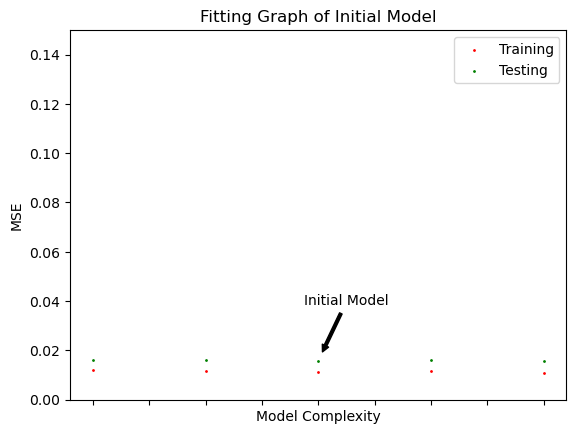

In [ ]:
complexities = [1, 2, 3, 4, 5]
train_mse = [low1_MSE_train, low2_MSE_train, initial_MSE_train, high1_MSE_train, high2_MSE_train]
test_mse = [low1_MSE_test, low2_MSE_test, initial_MSE_test, high1_MSE_test, high2_MSE_test]
plt.scatter(complexities, train_mse, s = 1, c='r', label='Training')
plt.scatter(complexities, test_mse, s = 1, c='g', label='Testing')
plt.xlabel('Model Complexity')
plt.xticks(visible=False)
plt.ylim(0, 0.15)
plt.ylabel('MSE')
plt.title('Fitting Graph of Initial Model')
plt.annotate('Initial Model', (complexities[2], test_mse[2]), textcoords='offset points', xytext=(-10, 40),
             arrowprops=dict(arrowstyle='simple', facecolor='black', shrinkB=7))
plt.legend()
plt.show()

## Improving the Initial Model

### Revision 1: Removing Undersampled Output Classes

In [9]:
# create new table with most significantly undersampled classes removed
# classes removed: 'Uploading_Attack' (23 samples), 'Recon-PingSweep' (41 samples), 'XSS' (72 samples), 'Backdoor_Malware' (76 samples),
# 'CommandInjection' (105 samples), 'SqlInjection' (122 samples), 'BrowserHijacking' (140 samples)
undersampled_classes = ['Uploading_Attack', 'Recon-PingSweep', 'XSS', 'Backdoor_Malware', 'CommandInjection', 'SqlInjection', 'BrowserHijacking']
reduced_intru_table = intru_table.loc[~intru_table['label'].isin(undersampled_classes)]
reduced_intru_labels_removed = reduced_intru_table.drop(columns=['label'])
reduced_intru_label_names = ['BenignTraffic', 'DDoS-ACK_Fragmentation', 'DDoS-HTTP_Flood', 'DDoS-ICMP_Flood',
                             'DDoS-ICMP_Fragmentation', 'DDoS-PSHACK_Flood', 'DDoS-RSTFINFlood', 'DDoS-SYN_Flood', 'DDoS-SlowLoris', 'DDoS-SynonymousIP_Flood',
                             'DDoS-TCP_Flood', 'DDoS-UDP_Flood', 'DDoS-UDP_Fragmentation', 'DNS_Spoofing', 'DictionaryBruteForce', 'DoS-HTTP_Flood', 'DoS-SYN_Flood',
                             'DoS-TCP_Flood', 'DoS-UDP_Flood', 'MITM-ArpSpoofing', 'Mirai-greeth_flood', 'Mirai-greip_flood', 'Mirai-udpplain', 'Recon-HostDiscovery',
                             'Recon-OSScan', 'Recon-PortScan', 'VulnerabilityScan']
attribute_data = reduced_intru_labels_removed.drop(columns=exclude)

# complete one-hot encoding on reduced intrusion labels
ohe = OneHotEncoder()
ohe_reduced_intru_labels = pd.DataFrame(ohe.fit_transform(reduced_intru_table['label'].values.reshape(-1,1)).toarray(), columns=reduced_intru_label_names)

# create normalized train and test sets for reduced data
X_train, X_test, y_train, y_test = train_test_split(attribute_data, ohe_reduced_intru_labels, train_size=0.9, random_state=5)
scaler = MinMaxScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=attribute_data.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=attribute_data.columns)

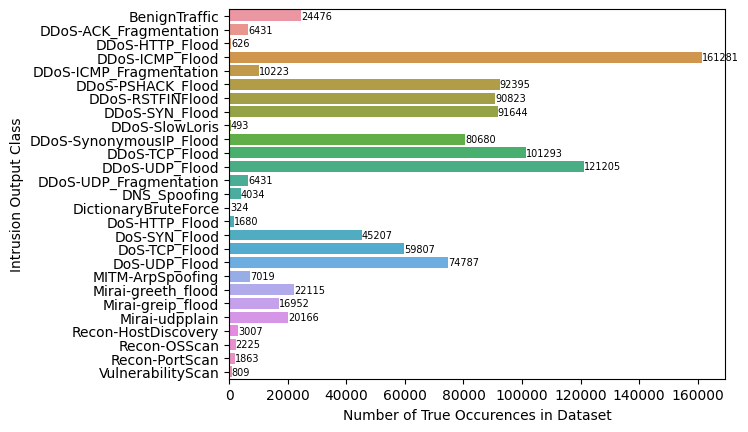

In [10]:
# show output class distribution of new dataset with undersampled classes removed
classes_true_count = []
for col in ohe_reduced_intru_labels:
    count = (ohe_reduced_intru_labels[col] == 1).sum()
    classes_true_count.append(count)
class_distru = pd.DataFrame({'Intrusion Output Class': ohe_reduced_intru_labels.columns, 'Number of True Occurences in Dataset': classes_true_count})
fig, ax = plt.subplots()
sns.barplot(x='Number of True Occurences in Dataset', y='Intrusion Output Class', data=class_distru)
for i in ax.containers:
    ax.bar_label(i, fontsize=7)

In [ ]:
# K-fold cross validation to generalize revised model performance with fewer classes, same input/hidden structure as initial (10 folds)
classifier = Sequential()
classifier.add(Dense(units = 36, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 35, activation = 'relu'))
classifier.add(Dense(units = 27, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
kfold_model = KFold(n_splits=10)

# calculate accuracy and MSE scores for each fold iteration
scaler = MinMaxScaler()
X = scaler.fit_transform(attribute_data)
y = ohe_reduced_intru_labels.values
all_accuracy = []
all_mse = []
count = 0
for train_index, test_index in kfold_model.split(X):
    count += 1
    classifier.fit(X[train_index].astype(float), y[train_index])
    bean_predictions_cla2 = pd.DataFrame(((classifier.predict(X[test_index].astype(float))) > 0.5).astype(int))
    iter_accuracy = accuracy_score(y[test_index], bean_predictions_cla2)
    print("\tIteration", count, "Accuracy:", iter_accuracy)
    all_accuracy.append(iter_accuracy)
    iter_mse = mean_squared_error(y[test_index], bean_predictions_cla2)
    print("\tIteration", count, "MSE:", iter_mse)
    all_mse.append(iter_mse)

# print results
print("Overall Avg. K-Fold Accuracy:", np.mean(all_accuracy))
print("Overall Avg. K-Fold MSE:", np.mean(all_mse))

3275/3275 [==============================] - 5s 2ms/step
	Iteration 1 Accuracy: 0.6740267175572519
	Iteration 1 MSE: 0.018403307888040715
3275/3275 [==============================] - 6s 2ms/step
	Iteration 2 Accuracy: 0.7632824427480916
	Iteration 2 MSE: 0.016265196494204128
3275/3275 [==============================] - 5s 1ms/step
	Iteration 3 Accuracy: 0.773530534351145
	Iteration 3 MSE: 0.015464729997172744
3275/3275 [==============================] - 6s 2ms/step
	Iteration 4 Accuracy: 0.7699809160305343
	Iteration 4 MSE: 0.015896239751201583
3275/3275 [==============================] - 5s 2ms/step
	Iteration 5 Accuracy: 0.7655534351145038
	Iteration 5 MSE: 0.016136556403731978
3275/3275 [==============================] - 4s 1ms/step
	Iteration 6 Accuracy: 0.7731583969465649
	Iteration 6 MSE: 0.01582025728018094
3275/3275 [==============================] - 5s 1ms/step
	Iteration 7 Accuracy: 0.7769444364927146
	Iteration 7 MSE: 0.015501278814860051
3275/3275 [=========================

### Revision 2: Creating a More Complex Neural Network for the Reduced Dataset

In [ ]:
classifier = Sequential()
classifier.add(Dense(units = 50, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 45, activation = 'relu'))
classifier.add(Dense(units = 40, activation = 'relu'))
classifier.add(Dense(units = 27, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train, y_train, epochs = 50)

Epoch 1/50
29475/29475 [==============================] - 67s 2ms/step - loss: 0.6743
Epoch 2/50
29475/29475 [==============================] - 60s 2ms/step - loss: 0.5115
Epoch 3/50
29475/29475 [==============================] - 56s 2ms/step - loss: 0.4840
Epoch 4/50
29475/29475 [==============================] - 57s 2ms/step - loss: 0.4717
Epoch 5/50
29475/29475 [==============================] - 55s 2ms/step - loss: 0.4643
Epoch 6/50
29475/29475 [==============================] - 57s 2ms/step - loss: 0.4596
Epoch 7/50
29475/29475 [==============================] - 57s 2ms/step - loss: 0.4560
Epoch 8/50
29475/29475 [==============================] - 55s 2ms/step - loss: 0.4533
Epoch 9/50
29475/29475 [==============================] - 61s 2ms/step - loss: 0.4510
Epoch 10/50
29475/29475 [==============================] - 54s 2ms/step - loss: 0.4488
Epoch 11/50
29475/29475 [==============================] - 58s 2ms/step - loss: 0.4470
Epoch 12/50
29475/29475 [===========================

In [ ]:
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_reduced_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
initial_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", initial_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_reduced_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_reduced_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
initial_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", initial_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_reduced_intru_labels.columns))

29475/29475 [==============================] - 52s 2ms/step
Model Training Accuracy (avg.): 0.7989240836475133
Model Training Precision (avg.): 0.7848045771319923
Model Training Recall (avg.): 0.6127010657292579
Model Training MSE: 0.014385329438616347
                         precision    recall  f1-score   support

          BenignTraffic       0.78      0.87      0.82     22114
 DDoS-ACK_Fragmentation       0.99      0.98      0.99      5791
        DDoS-HTTP_Flood       0.76      0.43      0.55       563
        DDoS-ICMP_Flood       1.00      1.00      1.00    145320
DDoS-ICMP_Fragmentation       1.00      0.98      0.99      9222
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83179
       DDoS-RSTFINFlood       1.00      1.00      1.00     81736
         DDoS-SYN_Flood       0.67      0.96      0.79     82639
         DDoS-SlowLoris       0.75      0.27      0.40       451
DDoS-SynonymousIP_Flood       0.92      0.56      0.70     72428
         DDoS-TCP_Flood       0

In [11]:
classifier = Sequential()
classifier.add(Dense(units = 70, activation = 'relu', input_dim = 33))
classifier.add(Dense(units = 60, activation = 'relu'))
classifier.add(Dense(units = 50, activation = 'relu'))
classifier.add(Dense(units = 40, activation = 'relu'))
classifier.add(Dense(units = 30, activation = 'relu'))
classifier.add(Dense(units = 27, activation = 'softmax'))
classifier.compile(optimizer = "SGD", loss = 'CategoricalCrossentropy')
classifier.fit(X_train, y_train, epochs = 50)

Epoch 1/50
29475/29475 [==============================] - 60s 2ms/step - loss: 0.6396
Epoch 2/50
29475/29475 [==============================] - 62s 2ms/step - loss: 0.4876
Epoch 3/50
29475/29475 [==============================] - 56s 2ms/step - loss: 0.4690
Epoch 4/50
29475/29475 [==============================] - 64s 2ms/step - loss: 0.4610
Epoch 5/50
29475/29475 [==============================] - 57s 2ms/step - loss: 0.4563
Epoch 6/50
29475/29475 [==============================] - 55s 2ms/step - loss: 0.4527
Epoch 7/50
29475/29475 [==============================] - 53s 2ms/step - loss: 0.4499
Epoch 8/50
29475/29475 [==============================] - 53s 2ms/step - loss: 0.4475
Epoch 9/50
29475/29475 [==============================] - 52s 2ms/step - loss: 0.4455
Epoch 10/50
29475/29475 [==============================] - 53s 2ms/step - loss: 0.4438
Epoch 11/50
29475/29475 [==============================] - 53s 2ms/step - loss: 0.4423
Epoch 12/50
29475/29475 [===========================

In [12]:
intru_predictions = pd.DataFrame(((classifier.predict(X_train.astype(float))) > 0.5).astype(int), columns=ohe_reduced_intru_labels.columns)
print("Model Training Accuracy (avg.):", accuracy_score(y_train, intru_predictions))
print("Model Training Precision (avg.):", precision_score(y_train, intru_predictions, average='macro'))
print("Model Training Recall (avg.):", recall_score(y_train, intru_predictions, average='macro'))
initial_MSE_train = mean_squared_error(y_train, intru_predictions)
print("Model Training MSE:", initial_MSE_train)
print(classification_report(y_train, intru_predictions, target_names=ohe_reduced_intru_labels.columns))

# measure performance on testing data
intru_predictions = pd.DataFrame(((classifier.predict(X_test.astype(float))) > 0.5).astype(int), columns=ohe_reduced_intru_labels.columns)
print("Model Testing Accuracy (avg.):", accuracy_score(y_test, intru_predictions))
print("Model Testing Precision (avg.):", precision_score(y_test, intru_predictions, average='macro'))
print("Model Testing Recall (avg.):", recall_score(y_test, intru_predictions, average='macro'))
initial_MSE_test = mean_squared_error(y_test, intru_predictions)
print("Model Testing MSE:", initial_MSE_test)
print(classification_report(y_test, intru_predictions, target_names=ohe_reduced_intru_labels.columns))

29475/29475 [==============================] - 41s 1ms/step
Model Training Accuracy (avg.): 0.7961388725143025
Model Training Precision (avg.): 0.7961346934383857
Model Training Recall (avg.): 0.6172572844437663
Model Training MSE: 0.014464414371750703
                         precision    recall  f1-score   support

          BenignTraffic       0.83      0.79      0.81     22114
 DDoS-ACK_Fragmentation       0.99      0.98      0.99      5791
        DDoS-HTTP_Flood       0.71      0.52      0.60       563
        DDoS-ICMP_Flood       1.00      1.00      1.00    145320
DDoS-ICMP_Fragmentation       1.00      0.97      0.99      9222
      DDoS-PSHACK_Flood       1.00      1.00      1.00     83179
       DDoS-RSTFINFlood       1.00      1.00      1.00     81736
         DDoS-SYN_Flood       0.67      0.95      0.79     82639
         DDoS-SlowLoris       0.74      0.36      0.48       451
DDoS-SynonymousIP_Flood       0.89      0.55      0.68     72428
         DDoS-TCP_Flood       0